In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, auc, roc_curve
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

# Load & prepare data
- Load fashion_mnist
- Prepare dataset for loading

In [2]:
(train_ds, valid_ds, test_ds), info_ds = tfds.load(
    'fashion_mnist', split=['train', 'test[:50]', 'test[50:]'],
    with_info=True, as_supervised=True, data_dir='data'
)

Shuffling and writing examples to data/fashion_mnist/3.0.1.incompleteP17SDD/fashion_mnist-train.tfrecord


Shuffling and writing examples to data/fashion_mnist/3.0.1.incompleteP17SDD/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
@tf.function
def prepare_data(image, label):
  return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10)

train_ds = train_ds.shuffle(len(train_ds)).map(prepare_data).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(prepare_data).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(prepare_data).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Build model
- Simple CNN following the jax version

In [4]:
class SimpleCNN(tf.keras.Model):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
    self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))

    self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
    self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))

    self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')
    self.pool3 = tf.keras.layers.MaxPooling2D((2, 2))

    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(256, activation='relu')
    self.dropout = tf.keras.layers.Dropout(0.25)
    self.fc2 = tf.keras.layers.Dense(10, activation='softmax')

  @tf.function
  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = self.pool3(x)

    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [5]:
model = SimpleCNN()
model.build((1, 28, 28, 1))
model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08)
loss = tf.keras.losses.CategoricalCrossentropy()

In [9]:
train_metrics = tf.keras.metrics.CategoricalAccuracy()
val_metrics = tf.keras.metrics.CategoricalAccuracy()

# Custom training loop

In [10]:
@tf.function
def train_step(train_image, train_label):
  with tf.GradientTape() as tape:
    logits = model(train_image)
    loss_val = loss(train_label, logits)

  grads = tape.gradient(loss_val, model.trainable_weights)
  # optimize weights
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  train_metrics.update_state(train_label, logits)

  return loss_val

@tf.function
def val_step(test_image, test_label):
  logits = model(test_image)
  loss_val = loss(test_label, logits)
  val_metrics.update_state(test_label, logits)
  return loss_val

In [14]:
for epoch in tqdm(range(10)):
  for step, (train_image, train_label) in tqdm(enumerate(train_ds), total=len(train_ds)):
    train_loss = train_step(train_image, train_label)
    if step % 200 == 0:
        print(
            "Training loss (for one batch) at step %d: %.4f"
            % (step, float(train_loss))
        )
        print("Seen so far: %s samples" % ((step + 1) * 64))

  for index, (val_image, val_label) in tqdm(enumerate(valid_ds), total=len(valid_ds)):
    test_loss = val_step(val_image, val_label)


Training loss (for one batch) at step 0: 0.4115
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.2308
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.2619
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4551
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.3419
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.3253
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3377
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3631
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.2996
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.3270
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.3234
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3046
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.2823
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.3580
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.3311
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.4774
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3482
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3227
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.3946
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.2134
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.3532
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3289
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3540
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.1971
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.3809
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.3604
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3659
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.4838
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.2865
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.2372
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.2888
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.2917
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.2833
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.3645
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.3363
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.3544
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.1808
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.5376
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.3162
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.2772
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.2815
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.5248
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.4205
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4215
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.2375
Seen so far: 51264 samples



Training loss (for one batch) at step 0: 0.2982
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3346
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3735
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.3399
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.2777
Seen so far: 51264 samples



# Evaluate model

In [20]:
# Forward pass 
true_labels = []
preds_labels = []
for test_image, test_label in tqdm(test_ds):
  true_labels.append(test_label.numpy().argmax(axis=1))
  preds_labels.append(model(test_image).numpy().argmax(axis=1))

true_label = np.concatenate(true_labels)
preds_labels = np.concatenate(preds_labels)

In [21]:
print(classification_report(true_label, preds_labels))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       993
           1       0.98      0.97      0.98       998
           2       0.76      0.84      0.80       995
           3       0.92      0.84      0.88       996
           4       0.78      0.78      0.78       990
           5       0.94      0.97      0.95       995
           6       0.69      0.56      0.62       998
           7       0.92      0.94      0.93       991
           8       0.96      0.97      0.97       999
           9       0.97      0.92      0.94       995

    accuracy                           0.87      9950
   macro avg       0.87      0.87      0.87      9950
weighted avg       0.87      0.87      0.87      9950



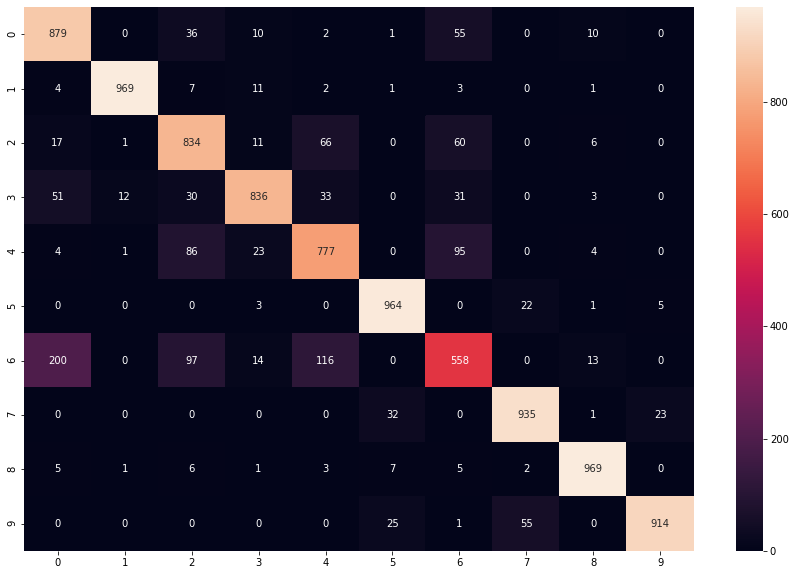

In [23]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(true_label, preds_labels), annot=True, fmt='d')

In [24]:
print('MCC Acc: {:.2f}'.format(matthews_corrcoef(true_label, preds_labels) * 100))

MCC Acc: 85.36


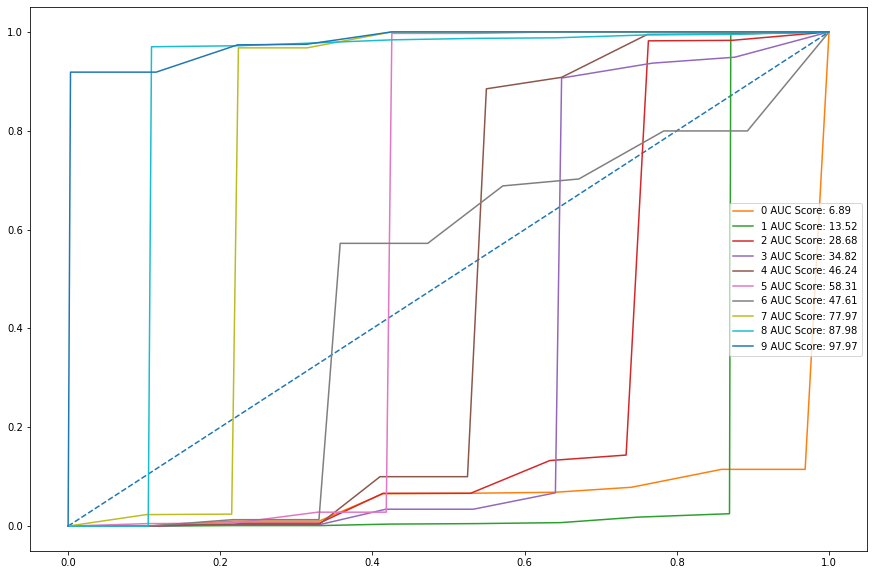

In [34]:
plt.figure(figsize=(15, 10))
ident = [0.0, 1.0]
plt.plot(ident,ident, '--')
for i in range(10):
  fpr, tpr, threshold = roc_curve(true_label, preds_labels, pos_label=i)
  auc_score = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=str(i) + ' AUC Score: ' + str(round(auc_score * 100, 2)))

plt.legend();